In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /Users/sumi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sumi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sumi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
df = pd.read_excel("repair_data.xlsx")  # Or 'repair_data.csv'

In [131]:
# Clean column names
df.columns = df.columns.str.strip()
# Drop unnecessary unnamed columns
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# If desired, filter to keep only essential ones
# df = df[['Customer comment', 'Repair comment']]
df.head()


,Job,Type,SN,Customer comment,Repair comment,Status,Date,Solveup,Noted,Power connector broken,all_comments,cleaned_comments,combined_terms_text,improved_combined_text
0,SC5351,DASH VIEW SR,00SR12D00180,UNIT NO LONGER CONNECTS TO MOBILE PHONE AND PH...,No WIFI ID to be found. Replace a brand new fr...,Done,2023-07-12 00:00:00,NaN,NaN,NaN,unit no longer connects to mobile phone and ph...,longer connects mobile wifi wifi found replace...,longer connects mobile wifi wifi found replace...,longer connects mobile wifi wifi found replace...
1,SC5353,DECT1735+1,28000198,NO DIAL TONE ON THE PHONE LINE,Conducted a test dial and left the message. Th...,Done,2023-07-12 00:00:00,NaN,- 12/07/23 Waiting new ticket to be opened\n-2...,NaN,no dial tone on the phone line conducted a tes...,dial tone line conducted dial left work proper...,dial tone line conducted dial left work proper...,dial tone line conducted dial left work proper...
2,SC5370,DECT1735+1,28001374,CRACKLING SOUNDS FROM MIC WHEN SPEAKING,Tested and checked all working - No fault foun...,Done,2023-07-13 00:00:00,8598608,NaN,NaN,crackling sounds from mic when speaking tested...,crackling sound mic speaking checked found han...,crackling sound mic speaking checked found han...,crackling sound mic speaking checked found han...
3,SC5375,DECT1735+1,28016969,BASE UNIT WILL NOT CHARGE THE HANDSETS,Fault has been confirmed. The base unit has be...,Done,2023-07-13 00:00:00,NaN,NaN,NaN,base unit will not charge the handsets fault h...,base charge handset base like base function pr...,base charge handset base like base function pr...,base charge handset base like base function pr...
4,SC5395,SSE45+1,28001187,HANDSET BUTTONS WILL NOT WORK ON SECOND HANDSET\n,The base adapter was not provided by customer....,Done,2023-07-13 00:00:00,8599264,NaN,NaN,handset buttons will not work on second handse...,handset button second handset base adapter fou...,handset button second handset base adapter fou...,handset button second handset base adapter fou...


In [139]:
print(df['Type'].unique())

['DASH VIEW SR' 'DECT1735+1' 'SSE45+1' 'DECT1735' 'XDECT8315+1' 'BW3000'
 'BW3001' 'BW3101' 'BW3451R' 'DECT1735+3' 'BW4301' 'SSE34' 'BW3101R'
 'SSE45' 'BW31PTZ' 'BW614PTR' 'BW6141R' 'SOLO PRO' 'SOLO PRO-4' 'SSE45W'
 'APPCAM SOLO+' 'BW5151R' 'BW6151R' 'BW4151' 'DECT1015' 'UPP1000'
 'BW515PTR' 'XDECT8315+1\n' 'SOLO PRO BK' 'BW4351' 'SOLO PRO-2'
 'XDECT8355+1' 'BW3102' 'DASHVIEW30R' 'IGOCAM80' 'BW6181R' 'IGOCAM90R'
 'UH850' 'UH820S-2TP' 'UH850H' 'UH820S' 'UH755' 'UH5060' 'UH5060VP'
 'UH6060' 'UH850S' 'SOLO4GKIT' 'GDVR20880' 'ADV25-2' 'UH9050' 'DEC1735+1'
 'DECT1735+2' 'BW5151R+1' 'DASHVIEW SXR' 'XTRAK50' nan 'GDVR20440'
 'APPCAM HOME+' 'XDECT8315' 'SOLOPRO2K' 'G3720' 'GXVR55880' 'XDECT8355+2'
 'IGOCAM30' 'UWG900' 'DASHVIEW 30R' 'GDVR4T40' 'SSE47+1' 'SOLO PT KIT'
 'IGOCAM90' 'DASHVIEW50R' 'DASHVIEW SR' 'IGOCAM50R' 'IGOCAM40' 'GDVR8T80'
 'IGOCAM60' 'SC6551' 'GDVR20400' 'IGOCAM70R' 'DASHVIEW SX' 'APPCAM SX'
 'DASHVIEW S' 'UPP44' 'DECT1715' 'GDVR8A42' 'IGOCAM75R' 'IGOCAM75'
 'FP1200' 'DASHVIE

In [149]:
# 🏷️ PRODUCT CATEGORIZATION BASED ON TYPE

import pandas as pd
import numpy as np

def categorize_product(type_value):
    """
    Categorize products based on Type column patterns
    """
    # Handle NaN or empty values
    if pd.isna(type_value) or type_value == '':
        return 'Unknown'
    
    # Convert to string and uppercase for consistent matching
    type_str = str(type_value).upper().strip()
    
    # Define categorization rules (order matters - more specific first)
    
    # Baby Monitor - starts with BW
    if type_str.startswith('BW'):
        return 'Baby Monitor'
    
    # Dash Cam - contains DASH or IGO
    if 'DASH' in type_str or 'IGO' in type_str:
        return 'Dash Cam'
    
    # Phone - contains DECT or SSE (cordless phones)
    if any(phone_indicator in type_str for phone_indicator in ['DECT', 'SSE', 'FP']):
        return 'Phone'
    
    # Camera - contains SOLO or APPCAM
    if 'SOLO' in type_str or 'APPCAM' in type_str:
        return 'Camera'
    
    # Recorder - contains DVR, NVR, CVR, or XVR
    if any(recorder_indicator in type_str for recorder_indicator in ['DVR', 'NVR', 'CVR', 'XVR']):
        return 'Recorder'
    
    if any(radio_indicator in type_str for radio_indicator in ['XTRAK', 'UH', 'MHS']):
        return 'Radio'
    
    if 'UPP' in type_str:
        return 'Power Supply'
    
    if 'SPS' in type_str:
        return 'Solar Panel'
    
    # Handle service/maintenance entries
    if any(service_word in type_str for service_word in ['CLEAN', 'SERVICE', 'TEST', 'NETWORK']):
        return 'Service/Maintenance'
    
    # Handle numeric-only entries
    if type_str.isdigit():
        return 'Unknown'
    
    # Default category for unmatched items
    return 'Other'

# Apply the categorization
print("🏷️ Creating Product categorization...")
df['Product'] = df['Type'].apply(categorize_product)

# Show the results
print("\n📊 PRODUCT CATEGORIZATION RESULTS:")
print("="*50)

# Count products by category
product_counts = df['Product'].value_counts()
print("Product distribution:")
for product, count in product_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {product:20} : {count:4d} ({percentage:5.1f}%)")

print(f"\nTotal records: {len(df)}")

# Show examples for each category
print(f"\n📋 EXAMPLES FOR EACH CATEGORY:")
print("="*60)

for category in df['Product'].unique():
    if pd.isna(category):
        continue
    
    print(f"\n🔸 {category.upper()}:")
    
    # Get examples of types for this category
    category_examples = df[df['Product'] == category]['Type'].value_counts().head(5)
    
    for type_name, count in category_examples.items():
        print(f"  • {type_name} ({count} times)")

# Show some actual data examples
print(f"\n📝 SAMPLE DATA WITH NEW PRODUCT COLUMN:")
print("="*70)

# Display first 10 rows with relevant columns
display_cols = ['Type', 'Product', 'all_comments']
sample_df = df[display_cols].head(10).copy()

# Truncate long comments for display
sample_df['all_comments'] = sample_df['all_comments'].str[:50] + '...'

print(sample_df.to_string(index=True, max_colwidth=50))

# Check for any unusual categorizations
print(f"\n🔍 CHECKING FOR UNUSUAL CATEGORIZATIONS:")
print("="*50)

# Show 'Other' category items to see if we missed anything
other_items = df[df['Product'] == 'Other']['Type'].value_counts()
if len(other_items) > 0:
    print("Items categorized as 'Other' (may need custom rules):")
    for item, count in other_items.head(10).items():
        print(f"  • {item} ({count} times)")
else:
    print("✅ No items in 'Other' category - all products successfully categorized!")

# Show service/maintenance entries
service_items = df[df['Product'] == 'Service/Maintenance']['Type'].value_counts()
if len(service_items) > 0:
    print(f"\nService/Maintenance entries found:")
    for item, count in service_items.head(5).items():
        print(f"  • {item} ({count} times)")

# Verification function to test categorization logic
def test_categorization():
    """Test the categorization with sample data"""
    print(f"\n🧪 TESTING CATEGORIZATION LOGIC:")
    print("="*40)
    
    test_cases = [
        ('BW3000', 'Baby Monitor'),
        ('DASHVIEW SR', 'Dash Cam'),
        ('IGOCAM80', 'Dash Cam'),
        ('DECT1735+1', 'Phone'),
        ('SSE45+1', 'Phone'),
        ('UH850', 'Phone'),
        ('SOLO PRO', 'Camera'),
        ('APPCAM SOLO+', 'Camera'),
        ('GDVR20880', 'Recorder'),
        ('GNVR8680', 'Recorder'),
        ('GCVR8H40', 'Recorder'),
        ('GXVR55880', 'Recorder'),
        ('FP1200', 'Accessory'),
        ('XTRAK50', 'GPS Tracker'),
        ('UPP1000', 'Power Supply'),
        ('Clean the pallet', 'Service/Maintenance'),
    ]
    
    print("Testing sample cases:")
    all_correct = True
    for test_type, expected in test_cases:
        result = categorize_product(test_type)
        status = "✅" if result == expected else "❌"
        print(f"  {status} '{test_type}' → {result} (expected: {expected})")
        if result != expected:
            all_correct = False
    
    if all_correct:
        print(f"\n🎉 All test cases passed!")
    else:
        print(f"\n⚠️ Some test cases failed - review categorization rules")

# Run the test
test_categorization()

# Create a summary for analysis
print(f"\n📈 SUMMARY FOR ANALYSIS:")
print("="*40)
print("New 'Product' column created successfully!")
print("You can now use this for:")
print("• Filtering by product type") 
print("• Topic modeling by product category")
print("• Issue frequency by product type")

# Show how to use the new column
print(f"\n💡 EXAMPLE USAGE:")
print("="*25)
print("# Filter by product type:")
print("baby_monitor_issues = df[df['Product'] == 'Baby Monitor']")
print("dash_cam_issues = df[df['Product'] == 'Dash Cam']")
print("")
print("# Analyze issues by product:")
print("df.groupby('Product')['all_comments'].count()")
print("")
print("# Topic modeling for specific products:")
print("camera_comments = df[df['Product'] == 'Camera']['cleaned_comments']")

print(f"\n✅ Product categorization complete!")
print(f"Added 'Product' column with {len(df['Product'].unique())} categories")

🏷️ Creating Product categorization...

📊 PRODUCT CATEGORIZATION RESULTS:
Product distribution:
  Dash Cam             :  675 ( 37.7%)
  Baby Monitor         :  361 ( 20.1%)
  Phone                :  303 ( 16.9%)
  Camera               :  265 ( 14.8%)
  Recorder             :   80 (  4.5%)
  Radio                :   36 (  2.0%)
  Unknown              :   36 (  2.0%)
  Other                :   13 (  0.7%)
  Power Supply         :   11 (  0.6%)
  Service/Maintenance  :   10 (  0.6%)
  Solar Panel          :    2 (  0.1%)

Total records: 1792

📋 EXAMPLES FOR EACH CATEGORY:

🔸 DASH CAM:
  • IGOCAM90R (220 times)
  • DASHVIEW SR (73 times)
  • DASHVIEW SXR (72 times)
  • DASHVIEW30R (57 times)
  • DASHVIEW50R (33 times)

🔸 PHONE:
  • SSE45+1 (50 times)
  • DECT1735+1 (44 times)
  • DECT1735 (28 times)
  • DECT1735+3 (28 times)
  • SSE45W (23 times)

🔸 BABY MONITOR:
  • BW6141R (87 times)
  • BW6181R (48 times)
  • BW6101R (36 times)
  • BW5151R (33 times)
  • BW4351 (26 times)

🔸 CAMERA:
  •

In [147]:
print(df.columns.tolist())

['Job', 'Type', 'SN', 'Customer comment', 'Repair comment', 'Status', 'Date', 'Solveup', 'Noted', 'Power connector broken', 'all_comments', 'cleaned_comments', 'combined_terms_text', 'improved_combined_text', 'Product']


In [151]:
df.head(5)

,Job,Type,SN,Customer comment,Repair comment,Status,Date,Solveup,Noted,Power connector broken,all_comments,cleaned_comments,combined_terms_text,improved_combined_text,Product
0,SC5351,DASH VIEW SR,00SR12D00180,UNIT NO LONGER CONNECTS TO MOBILE PHONE AND PH...,No WIFI ID to be found. Replace a brand new fr...,Done,2023-07-12 00:00:00,NaN,NaN,NaN,unit no longer connects to mobile phone and ph...,longer connects mobile wifi wifi found replace...,longer connects mobile wifi wifi found replace...,longer connects mobile wifi wifi found replace...,Dash Cam
1,SC5353,DECT1735+1,28000198,NO DIAL TONE ON THE PHONE LINE,Conducted a test dial and left the message. Th...,Done,2023-07-12 00:00:00,NaN,- 12/07/23 Waiting new ticket to be opened\n-2...,NaN,no dial tone on the phone line conducted a tes...,dial tone line conducted dial left work proper...,dial tone line conducted dial left work proper...,dial tone line conducted dial left work proper...,Phone
2,SC5370,DECT1735+1,28001374,CRACKLING SOUNDS FROM MIC WHEN SPEAKING,Tested and checked all working - No fault foun...,Done,2023-07-13 00:00:00,8598608,NaN,NaN,crackling sounds from mic when speaking tested...,crackling sound mic speaking checked found han...,crackling sound mic speaking checked found han...,crackling sound mic speaking checked found han...,Phone
3,SC5375,DECT1735+1,28016969,BASE UNIT WILL NOT CHARGE THE HANDSETS,Fault has been confirmed. The base unit has be...,Done,2023-07-13 00:00:00,NaN,NaN,NaN,base unit will not charge the handsets fault h...,base charge handset base like base function pr...,base charge handset base like base function pr...,base charge handset base like base function pr...,Phone
4,SC5395,SSE45+1,28001187,HANDSET BUTTONS WILL NOT WORK ON SECOND HANDSET\n,The base adapter was not provided by customer....,Done,2023-07-13 00:00:00,8599264,NaN,NaN,handset buttons will not work on second handse...,handset button second handset base adapter fou...,handset button second handset base adapter fou...,handset button second handset base adapter fou...,Phone


In [17]:
# 📋 Step 3: Combine Text Columns
# Focus on the two main columns
df['all_comments'] = df['Customer comment'].astype(str)+ " " + df['Repair comment'].astype(str)
df['all_comments'] = df['all_comments'].fillna("").str.lower()
df.loc[10, 'all_comments']

'screen has blackout marks on bottom left hand side fault has been confirmed. the monitor has been replaced with a refurbished unit. - new sn - 3001l1r0182r'

In [81]:
# 🧹 Step 4: Text Cleaning and Preprocessing
stop_words = set(stopwords.words("english"))

administrative_words = {
    # Process words
    'unable', 'detect', 'please', 'find', 'check', 'test', 'tested', 'testing',
    'confirm', 'confirmed', 'confirming', 'recommend', 'recommended', 'suggest',
    'provide', 'provided', 'receive', 'received', 'send', 'sent', 'attached',
    'contact', 'call', 'phone', 'message', 'email', 'report', 'reported',
    
    # Time/frequency words
    'every', 'month', 'week', 'day', 'time', 'daily', 'weekly', 'monthly',
    'year', 'today', 'yesterday', 'tomorrow', 'often', 'sometimes', 'always',
    
    # Generic device words
    'unit', 'device', 'product', 'item', 'equipment', 'system', 'model',
    'brand', 'type', 'version', 'serial', 'number', 'sn', 'id',
    
    # Status words
    'new', 'old', 'used', 'working', 'work', 'function', 'functioning',
    'operational', 'replaced', 'replacement', 'refurbished', 'repair',
    'fixed', 'broken', 'faulty', 'fault', 'issue', 'problem',
    
    # Service words
    'customer', 'client', 'user', 'technician', 'service', 'support',
    'warranty', 'covered', 'coverage', 'claim', 'case', 'ticket',
    
    # Connector words and fillers
    'via', 'app', 'due', 'cause', 'caused', 'result', 'resulted',
    'make', 'made', 'get', 'got', 'put', 'take', 'give', 'need', 'want',
    'see', 'look', 'show', 'display', 'appear', 'seem', 'become',
    
    # Technical process words
    'reset', 'restart', 'reboot', 'update', 'updated', 'upgrade', 'install',
    'uninstall', 'download', 'upload', 'sync', 'connect', 'disconnect',
    
    # Measurement/assessment words
    'level', 'rate', 'speed', 'performance', 'quality', 'condition',
    'status', 'state', 'mode', 'setting', 'option', 'feature'
}
stop_words.update(administrative_words)

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation but keep spaces
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove numbers (but keep important tech terms)
    text = re.sub(r'\b\d+\b', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned_comments'] = df['all_comments'].apply(clean_text)


print("\n=== BEFORE vs AFTER IMPROVED CLEANING ===")
for i in range(5):
    print(f"\nOriginal: {df['all_comments'].iloc[i]}")
    print(f"Cleaned:  {df['cleaned_comments'].iloc[i]}")


=== BEFORE vs AFTER IMPROVED CLEANING ===

Original: unit no longer connects to mobile phone and phone wifi no wifi id to be found. replace a brand new front camera with serial s/n:000s12d00265.
customer's e-toll tag returned with the unit.
no sd card received
Cleaned:  longer connects mobile wifi wifi found replace front camera n 000s12d00265 e toll tag returned sd card

Original: no dial tone on the phone line conducted a test dial and left the message. the product works properly. please check your phone line.

**handset#2 was out of range. it has been reset and registered the handset #2 to the base. now it's working.
Cleaned:  dial tone line conducted dial left work properly line handset range registered handset base

Original: crackling sounds from mic when speaking tested and checked all working - no fault found. both handsets work properly. please check phone line connection before use.

Cleaned:  crackling sound mic speaking checked found handset properly line connection use

O

In [119]:
def combine_related_terms(text):
    """
    Combine related terms that should be treated as single concepts
    """
    # Convert to lowercase for consistent matching
    text = text.lower()
    
    # Define term combinations (order matters - longer phrases first!)
    term_combinations = {
        # Hardware components
        r'\b(sd\s+card|micro\s+sd|sd\s+memory|memory\s+card)\b': 'sd_card',
        r'\b(front\s+camera|rear\s+camera|back\s+camera)\b': 'camera_front' if 'front' in text else 'camera_rear',
        r'\b(charging\s+port|usb\s+port|power\s+port)\b': 'charging_port',
        r'\b(ac\s+adaptor|ac\s+adapter|power\s+adaptor|power\s+adapter)\b': 'ac_adaptor',
        r'\b(usb\s+cable|charging\s+cable|power\s+cable)\b': 'usb_cable',
        r'\b(wifi\s+connection|wireless\s+connection)\b': 'wifi_connection',
        r'\b(voice\s+message|voice\s+mail)\b': 'voice_message',
        r'\b(water\s+damage|liquid\s+damage)\b': 'water_damage',
        r'\b(screen\s+protector|tempered\s+glass)\b': 'screen_protector',
        r'\b(home\s+button|power\s+button|volume\s+button)\b': 'button_control',
        
        # Device types
        r'\b(dash\s+cam|dash\s+camera|car\s+camera)\b': 'dashcam',
        r'\b(mobile\s+phone|cell\s+phone|smart\s+phone)\b': 'smartphone',
        r'\b(tablet\s+pc|ipad|android\s+tablet)\b': 'tablet',
        r'\b(laptop\s+computer|notebook\s+computer)\b': 'laptop',
        
        # Issues/problems
        r'\b(not\s+working|does\s+not\s+work|stopped\s+working)\b': 'not_working',
        r'\b(battery\s+drain|battery\s+life|battery\s+issue)\b': 'battery_problem',
        r'\b(connection\s+issue|connectivity\s+problem)\b': 'connection_issue',
        r'\b(software\s+update|firmware\s+update)\b': 'software_update',
        r'\b(factory\s+reset|hard\s+reset)\b': 'factory_reset',
        
        # Actions/services
        r'\b(data\s+recovery|file\s+recovery)\b': 'data_recovery',
        r'\b(screen\s+replacement|display\s+replacement)\b': 'screen_replacement',
        r'\b(battery\s+replacement|new\s+battery)\b': 'battery_replacement',
    }
    
    # Apply combinations
    for pattern, replacement in term_combinations.items():
        text = re.sub(pattern, replacement, text)
    
    # Handle special case for front/rear camera based on context
    if 'front' in text and 'camera' in text:
        text = re.sub(r'\bfront\s+camera\b', 'front_camera', text)
    if 'rear' in text and 'camera' in text:
        text = re.sub(r'\brear\s+camera\b', 'rear_camera', text)
    if 'back' in text and 'camera' in text:
        text = re.sub(r'\bback\s+camera\b', 'rear_camera', text)
    
    return text


# 🔧 IMPROVED TERM COMBINATION DISPLAY

# Show ALL examples first (not just changed ones)
print("🔧 Combining related terms...")
df['combined_terms_text'] = df['cleaned_comments'].apply(combine_related_terms)

print("\n📋 FIRST 10 EXAMPLES (ALL):")
print("="*70)
for i in range(min(10, len(df))):  # Ensure we don't exceed DataFrame length
    original = df['cleaned_comments'].iloc[i] 
    combined = df['combined_terms_text'].iloc[i]
    
    print(f"\nExample {i+1}:")
    print(f"BEFORE: {original}")
    print(f"AFTER:  {combined}")
    
    # Show if any changes were made
    if original != combined:
        print("  🔄 CHANGES DETECTED!")
    else:
        print("  ✅ No changes (no combinable terms found)")

# Show only examples with changes (but search more broadly)
print(f"\n📋 EXAMPLES WHERE TERMS WERE COMBINED:")
print("="*70)

changes_found = 0
max_examples = 10

for i in range(len(df)):
    if changes_found >= max_examples:
        break
        
    original = df['cleaned_comments'].iloc[i]
    combined = df['combined_terms_text'].iloc[i]
    
    if original != combined:  # Changes were made
        changes_found += 1
        print(f"\nChanged Example {changes_found}:")
        print(f"BEFORE: {original}")
        print(f"AFTER:  {combined}")
        
        # Highlight what specifically changed
        print("  🔍 Specific changes:")
        if 'sd_card' in combined and 'sd_card' not in original:
            print("    • SD card terms combined")
        if 'camera_front' in combined and 'camera_front' not in original:
            print("    • Front camera terms combined") 
        if 'camera_rear' in combined and 'camera_rear' not in original:
            print("    • Rear camera terms combined")
        if 'charging_port' in combined and 'charging_port' not in original:
            print("    • Charging port terms combined")
        if 'ac_adaptor' in combined and 'ac_adaptor' not in original:
            print("    • AC adaptor terms combined")
        if 'dashcam' in combined and 'dashcam' not in original:
            print("    • Dashcam terms combined")

if changes_found == 0:
    print("⚠️  No term combinations found in the data!")
    print("This could mean:")
    print("  1. Your data doesn't contain multi-word terms like 'SD card', 'front camera'")
    print("  2. The terms are already in a different format")
    print("  3. The combination patterns need adjustment")
    
    print(f"\n🔍 Let's check what terms are actually in your data:")
    
    # Analyze what terms are present
    all_text = " ".join(df['cleaned_comments'].astype(str))
    
    # Check for potential combinable terms
    potential_terms = {
        'SD card related': ['sd', 'card', 'memory', 'micro'],
        'Camera related': ['camera', 'front', 'rear', 'back'],
        'Charging related': ['charging', 'port', 'usb', 'power'],
        'Adaptor related': ['adaptor', 'adapter', 'ac', 'power'],
        'Connection related': ['wifi', 'connection', 'wireless'],
        'Device related': ['dash', 'cam', 'dashcam', 'phone']
    }
    
    print("\n📊 TERMS FOUND IN YOUR DATA:")
    for category, terms in potential_terms.items():
        found_terms = [term for term in terms if term in all_text.lower()]
        if found_terms:
            print(f"  {category}: {', '.join(found_terms)}")

# Show statistics
print(f"\n📊 STATISTICS:")
print(f"Total comments processed: {len(df)}")
print(f"Comments with term combinations: {changes_found}")
print(f"Percentage with combinations: {(changes_found/len(df)*100):.1f}%")

# Improved combination function with more patterns
def improved_combine_related_terms(text):
    """
    Enhanced version with more combination patterns
    """
    if pd.isna(text) or text == '':
        return text
        
    text = str(text).lower()
    
    # More comprehensive term combinations
    combinations = [
        # SD card variations
        (r'\bsd\s+card\b', 'sd_card'),
        (r'\bmicro\s+sd\b', 'sd_card'),
        (r'\bmemory\s+card\b', 'sd_card'),
        (r'\bsd\s+storage\b', 'sd_card'),
        
        # Camera variations
        (r'\bfront\s+camera\b', 'front_camera'),
        (r'\brear\s+camera\b', 'rear_camera'),
        (r'\bback\s+camera\b', 'rear_camera'),
        (r'\bcamera\s+front\b', 'front_camera'),
        (r'\bcamera\s+rear\b', 'rear_camera'),
        
        # Charging variations
        (r'\bcharging\s+port\b', 'charging_port'),
        (r'\busb\s+port\b', 'charging_port'),
        (r'\bpower\s+port\b', 'charging_port'),
        (r'\bcharge\s+port\b', 'charging_port'),
        
        # Adaptor variations
        (r'\bac\s+adaptor\b', 'ac_adaptor'),
        (r'\bac\s+adapter\b', 'ac_adaptor'),
        (r'\bpower\s+adaptor\b', 'ac_adaptor'),
        (r'\bpower\s+adapter\b', 'ac_adaptor'),
        
        # Cable variations
        (r'\busb\s+cable\b', 'usb_cable'),
        (r'\bcharging\s+cable\b', 'usb_cable'),
        (r'\bpower\s+cable\b', 'usb_cable'),
        
        # Device variations
        (r'\bdash\s+cam\b', 'dashcam'),
        (r'\bdash\s+camera\b', 'dashcam'),
        (r'\bcar\s+camera\b', 'dashcam'),
        
        # Problem variations
        (r'\bnot\s+working\b', 'not_working'),
        (r'\bstop\s+working\b', 'not_working'),
        (r'\bdoes\s+not\s+work\b', 'not_working'),
        
        # Battery variations
        (r'\bbattery\s+drain\b', 'battery_problem'),
        (r'\bbattery\s+life\b', 'battery_problem'),
        (r'\bbattery\s+issue\b', 'battery_problem'),
        
        # Water damage
        (r'\bwater\s+damage\b', 'water_damage'),
        (r'\bliquid\s+damage\b', 'water_damage'),
    ]
    
    # Apply all combinations
    for pattern, replacement in combinations:
        text = re.sub(pattern, replacement, text)
    
    return text

# Test the improved function
print(f"\n🔧 TESTING IMPROVED COMBINATION FUNCTION:")
print("="*50)

df['improved_combined_text'] = df['cleaned_comments'].apply(improved_combine_related_terms)

# Show examples with the improved function
improved_changes = 0
for i in range(len(df)):
    if improved_changes >= 5:  # Show first 5 examples
        break
        
    original = df['cleaned_comments'].iloc[i]
    improved = df['improved_combined_text'].iloc[i]
    
    if original != improved:
        improved_changes += 1
        print(f"\nImproved Example {improved_changes}:")
        print(f"BEFORE: {original}")
        print(f"AFTER:  {improved}")

print(f"\nImproved function found {improved_changes} combinations")

# Use the improved version going forward
df['combined_terms_text'] = df['improved_combined_text']

🔧 Combining related terms...

📋 FIRST 10 EXAMPLES (ALL):

Example 1:
BEFORE: longer connects mobile wifi wifi found replace front camera n 000s12d00265 e toll tag returned sd card
AFTER:  longer connects mobile wifi wifi found replace camera_front n 000s12d00265 e toll tag returned sd_card
  🔄 CHANGES DETECTED!

Example 2:
BEFORE: dial tone line conducted dial left work properly line handset range registered handset base
AFTER:  dial tone line conducted dial left work properly line handset range registered handset base
  ✅ No changes (no combinable terms found)

Example 3:
BEFORE: crackling sound mic speaking checked found handset properly line connection use
AFTER:  crackling sound mic speaking checked found handset properly line connection use
  ✅ No changes (no combinable terms found)

Example 4:
BEFORE: base charge handset base like base function properly battery use
AFTER:  base charge handset base like base function properly battery use
  ✅ No changes (no combinable terms found)


In [121]:
# 🔍 Step 5: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_df=0.8, min_df=3,max_features=1000,ngram_range=(1,2))
tfidf_matrix = tfidf.fit_transform(df['combined_terms_text'])

# Check most important keywords globally
feature_names = tfidf.get_feature_names_out()
dense = tfidf_matrix.todense()
denselist = dense.tolist()
tfidf_df = pd.DataFrame(denselist, columns=feature_names)
tfidf_df.head()

,16gb,16gb minimum,2k,4g,4ghz,4ghz wifi,5ghz,able,ac_adaptor,ac_adaptor camera,...,wont turn,work,work expected,work properly,worked,worked expected,worked fine,worked properly,would,yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.159142,0.0,0.211875,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.223998,0.0,0.298223,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
product_categories = df['Product'].dropna().unique()

for product in product_categories:
    print("="*80)
    print(f"🔍 TOPIC MODELING FOR PRODUCT: {product}")
    
    # Subset by product
    df_sub = df[df['Product'] == product]
    
    # Skip if not enough rows
    if df_sub.shape[0] < 5:
        print("⚠️ Not enough data for topic modeling.\n")
        continue
    
    # Vectorize
    tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df_sub['combined_terms_text'])

    if tfidf_matrix.shape[0] < 5 or tfidf_matrix.shape[1] < 5:
        print("⚠️ Not enough unique vocabulary. Skipping...\n")
        continue
    
    # LDA model
    lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
    lda_model.fit(tfidf_matrix)

    # Show topics
    def display_topics(model, feature_names, no_top_words=10):
        for idx, topic in enumerate(model.components_):
            top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
            print(f"\n🔸 Topic #{idx + 1}:")
            print(", ".join(top_words))

    display_topics(lda_model, tfidf.get_feature_names_out())
    print("\n")

🔍 TOPIC MODELING FOR PRODUCT: Dash Cam

🔸 Topic #1:
front_camera, turn, wifi, sd_card, stopped, screen, dashcam, camera, recording, power

🔸 Topic #2:
sd_card, minimum, dashcam, card, file, corrupted, formatting, malfunction, class, prevent

🔸 Topic #3:
sd_card, battery, high, endurance, camera, additionally, dashcam, kit, loop, hardwire

🔸 Topic #4:
rear_camera, bracket, front_camera, loose, cable, camera, wifi, mounting, mount, function

🔸 Topic #5:
power, front_camera, sd_card, recording, cost, camera, button, turning, replace, issue


🔍 TOPIC MODELING FOR PRODUCT: Phone

🔸 Topic #1:
base, range, handset, voice, message, power, ac_adaptor, wont, long, expected

🔸 Topic #2:
button, answering, machine, ring, work, select, bank, message, pressed, expected

🔸 Topic #3:
base, battery, main, ac_adaptor, handset, use, power, ok, charge, function

🔸 Topic #4:
base, ok, handset, charging, power, station, ac_adaptor, cradle, registered, register

🔸 Topic #5:
handset, line, telephone, base, au

In [125]:
def display_topics_enhanced(model, feature_names, no_top_words):
    print("\n" + "="*60)
    print("TOPIC MODELING RESULTS")
    print("="*60)
    
    for idx, topic in enumerate(model.components_):
        print(f"\n🔸 Topic #{idx + 1}:")
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print("   " + ", ".join(top_words))
        
        # Show strength of top 3 words
        top_indices = topic.argsort()[:-4:-1]
        print("   Strength: ", end="")
        for i, word_idx in enumerate(top_indices):
            print(f"{feature_names[word_idx]}({topic[word_idx]:.3f})", end="")
            if i < 2: print(", ", end="")
        print()

# Try different numbers of topics
for n_topics in [3, 4, 5, 6]:
    print(f"\n{'='*20} TRYING {n_topics} TOPICS {'='*20}")
    
    lda = LatentDirichletAllocation(
        n_components=n_topics, 
        random_state=42,
        max_iter=20,           # More iterations for better convergence
        learning_method='batch' # More stable than 'online'
    )
    
    lda.fit(tfidf_matrix)
    display_topics_enhanced(lda, tfidf.get_feature_names_out(), 10)


==================== TRYING 3 TOPICS ====================

TOPIC MODELING RESULTS

🔸 Topic #1:
   monitor, camera, screen, battery, charge, handset, range, line, turn, power
   Strength: monitor(77.902), camera(65.713), screen(35.821)

🔸 Topic #2:
   sd_card, front_camera, dashcam, camera, recording, minimum, rear_camera, kit, firmware, turn
   Strength: sd_card(93.896), front_camera(44.601), dashcam(41.548)

🔸 Topic #3:
   base, wifi, handset, power, replace, cost, ac_adaptor, found, camera, box
   Strength: base(50.863), wifi(31.643), handset(28.406)

==================== TRYING 4 TOPICS ====================

TOPIC MODELING RESULTS

🔸 Topic #1:
   monitor, camera, screen, power, turn, charge, cable, ok, button, found
   Strength: monitor(69.090), camera(56.368), screen(33.759)

🔸 Topic #2:
   sd_card, dashcam, front_camera, camera, recording, minimum, rear_camera, kit, firmware, keep
   Strength: sd_card(93.824), dashcam(40.730), front_camera(38.389)

🔸 Topic #3:
   base, ac_adaptor

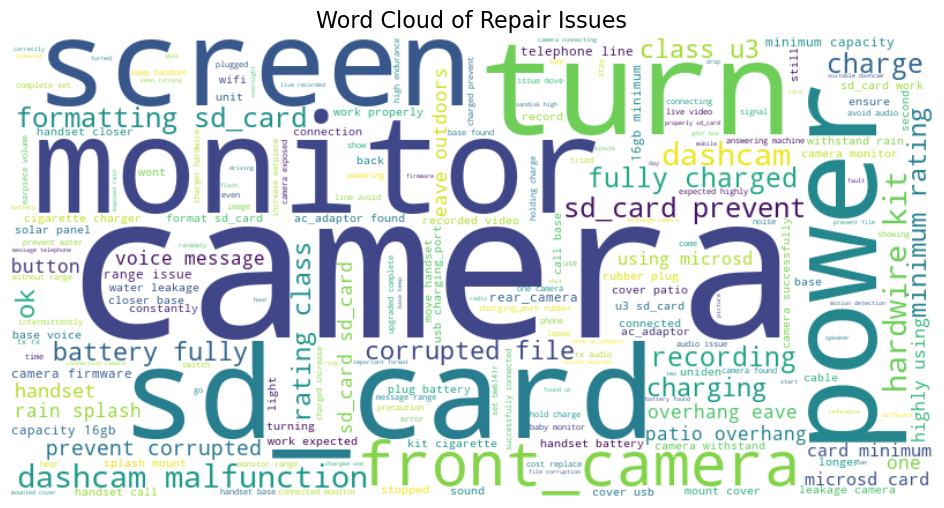

In [127]:
# ☁️ Step 7: Word Cloud Visualization
text = " ".join(df['combined_terms_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Repair Issues", fontsize=16)
plt.show()

/var/folders/w5/nyp7f5y53w53xb69z47g2g3h0000gn/T/ipykernel_1820/963257730.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette="Blues_d")


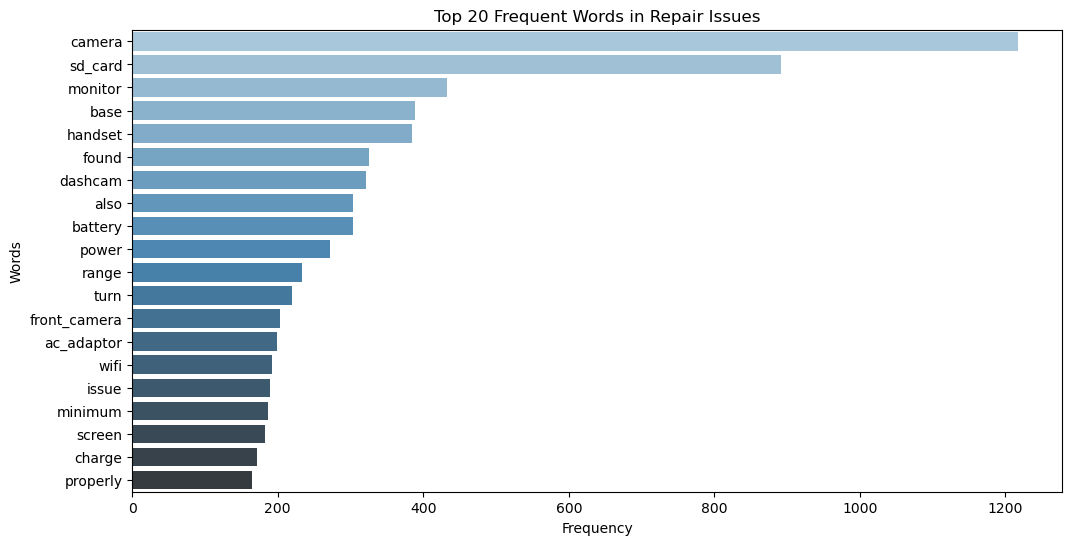

In [129]:
# 📊 Step 8: Frequency Plot
# Optional: Count the top 20 most frequent words
from collections import Counter

all_words = " ".join(df['combined_terms_text']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

words, freqs = zip(*common_words)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(freqs), y=list(words), palette="Blues_d")
plt.title("Top 20 Frequent Words in Repair Issues")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()